# Poker and Maze games using Reinforcement Learning



<font color="blue"> Surya Pavan Malireddy </font>

# I. Overview

The ojective of this assignment is to get familiar with reinforcement learning, implement maze game and poker game using different approaches such as SARSA, Q-Learning. I learned this reward based learning approach, implemented MazeAgent and PokerAgent to learn based on rewards using Q-Learning methodology. 

# II. Problems 

## A. Maze Problem (Practice)

Describe the problem. Read the following code and explain the GridWorld environment. 

##### Description of maze problem: 
A maze is a collection of paths from starting point to goal. Our aim is to start at a valid point in maze and move towards goal point through a valid path. Valid path should include only blocks through which we can move such as open space. Any blocks such as wall or obstacles in path is not a valid one.

Our maze environment is a 2 dimensional matrix with blocks of 'O'(open space), 'H'(Wall or obstacles) and 'G'(Goal location). Our path should have all 'O' blocks to reach goal 'G'. Using Reinforcement Learning, we generate possible paths from every point in maze to reach goal. 


##### GridWorld:
GridWorld class defines four actions that can be performed by an agent. For each action performed to reach goal, there is a reward of -1 point. If we hit obstacle or move out of grid there is a reward of -5, if we reach goal the reward is 30 points. This is accomplished in the below methods:  
a. Constructor: It initializes map from input file, defines possible actions, sets goal position.  
b. read_map: Reads input file and sets map of maze.    
c. init: Sets the given point as starting point in maze.  
d. check_state: Validates a given state.    
e. get_cur_state: Gets the current state of agent.  
f. next: agent is moved to next state based on given action. Reward is calculated using check_state method for new state.  
g. is_goal: To verify if agent reached goal.  

In [10]:
import collections
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Sample Grid Environment File

Simple text file with three characters, 'O', 'H', and 'G'.
- 'O': open space
- 'H': Wall or obstacles
- 'G': Goal location 

In [11]:
%%bash 
cat grid.txt

OOOHOOOOO
OOOHOOHOO
OOOOOOHOO
OOOOHHHOO
OOHOOOOOH
OOHOOOGOO
OOOOOOOOO

### GridWorld Class


In [89]:
# maze example

class GridWorld:
    """ Grid World environment
            there are four actions (left, right, up, and down) to move an agent
            In a grid, if it reaches a goal, it get 30 points of reward.
            If it falls in a hole or moves out of the grid world, it gets -5.
            Each step costs -1 point. 

        to test GridWorld, run the following sample codes:

            env = GridWorld('grid.txt')

            env.print_map()
            print [2,3], env.check_state([2,3])
            print [0,0], env.check_state([0,0])
            print [3,4], env.check_state([3,4])
            print [10,3], env.check_state([10,3])

            env.init([0,0])
            print env.next(1)  # right
            print env.next(3)  # down
            print env.next(0)  # left
            print env.next(2)  # up
            print env.next(2)  # up

        Parameters
        ==========
        _map        ndarray
                    string array read from a file input
        _size       1d array
                    the size of _map in ndarray
        goal_pos    tuple
                    the index for the goal location
        _actions    list
                    list of actions for 4 actions
        _s          1d array
                    current state
    """
    def __init__(self, fn):
        # read a map from a file
        self._map = self.read_map(fn)
        self._size = np.asarray(self._map.shape)
        self.goal_pos = np.where(self._map == 'G')

        # definition of actions (left, right, up, and down repectively)
        self._actions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self._s = None

    def get_cur_state(self):
        return self._s

    def get_size(self):
        return self._size

    def read_map(self, fn):
        grid = []
        with open(fn) as f:
            for line in f:
               grid.append(list(line.strip()))
        return np.asarray(grid)

    def print_map(self):
        print( self._map )

    def check_state(self, s):
        if isinstance(s, collections.Iterable) and len(s) == 2:
            if s[0] < 0 or s[1] < 0 or\
               s[0] >= self._size[0] or s[1] >= self._size[1]:
               return 'N'
            return self._map[tuple(s)].upper()
        else:
            return 'F'  # wrong input

    def init(self, state=None):
        if state is None:
            s = [0, 0]
        else:
            s = state

        if self.check_state(s) == 'O':
            self._s = np.asarray(state)
        else:
            raise ValueError("Invalid state for init")

    def next(self, a):
        s1 = self._s + self._actions[a]
        # state transition
        curr = self.check_state(s1)
        
        if curr == 'H' or curr == 'N':
            return -5
        elif curr == 'F':
            warnings.warn("invalid state " + str(s1))
            return -5
        elif curr == 'G':
            self._s = s1
            return 30
        else:
            self._s = s1
            return -1
        
    def is_goal(self):
        return self.check_state(self._s) == 'G'
            
    def get_actions(self):
        return self._actions

In [90]:
env = GridWorld("grid.txt")
env.print_map()

[['O' 'O' 'O' 'H' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'H' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'H' 'H' 'H' 'O' 'O']
 ['O' 'O' 'H' 'O' 'O' 'O' 'O' 'O' 'H']
 ['O' 'O' 'H' 'O' 'O' 'O' 'G' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]


In [91]:
# top-left to (0,0)
def coord_convert(s, sz):
    return [s[1], sz[0]-s[0]-1]

## B. One-Card Poker  

##### Description of poker problem:
Poker is a one card game played among 2 or more players with an objective to empty other players bet amount. Unique cards in this game are 1 to 13. There are a total of 2 rounds where each player can bet 0,1,2,3 with repect to current state of game. Each player starts game with a bet of 1. In round 1, if a player bets more than other players, only other players get chance to either match the bet or fold the game in round 2. In round 2, if bet is matched, cards are revealed and the player with maximum value card wins the game and total bet amount. If bet is not matched in round 2, player with highest bet amount wins the game and total bet amount. Game is continued until a player wins all other players bet amount.

In a game between 2 players each player starts game with his share of 10 and bets 1 before starting. Each player gets a card randomly and doesn't show it to others. In round 1 , players 1 bets 3 for his card numbered 10 and player 2 bets 2 for his card numbered 8. In round 2, player 2 has one more chance to either raise his bet or fold the game(0). Now player 2 raises bet by 1 to a total of 3. The total bet amount in pot is 8(1+1+3+2+1). Both players reveal their cards, player 1 wins the game with a reward of 8(total in pot). This is continued until one player has no more amount to play the game.

![](http://www.poker-vibe.com/poker/terms/case-card/Case-Card.jpg)

<font color="red"> Game Introduction and Rules: </font>
1. This is a 1-card poker game. Where each player can blindly bet from 0 (fold), 1, 2 or 3 in the first round. In the next round only the player who havent matched the max amount( from all the players) will be given a chance to bet additional amount to match or fold. 


2. Each player will be able to see his/her own card and the total pot balance and all other player's balance and their current bet on for the round i.e this is what you can call the current state of the game. <br>

    a. <font color="red"> Example1 </font>: 3 players in game i.e. player1, computer1, computer2. First round, player1        bets 3, computer1 bets 2 and computer2 bets 1. Next round only computer1 and computer2 will be given a chance          to match the bet as player1 has max bet so computer1's available actions will be (0, 1) and computer2's                available actions will be (0, 2).<br>
    
    b. After they match or fold the result will be given. <br>
    
    c. This case is applicable for player1 being the one who needs to match. <font color="red"> Example2 </font>: 3          players in game i.e player1, computer1, computer2. First round, player1 bets 1, computer1 bets 2 and                  computer2 bets 3. Next round only player1 and computer1 will have chance to bet and match or fold. <br>
       
    d. The examples described above will be 1 round each, this will continue until player1 losses all the money or            computer1 and computer2 will be out of money. <br>
    
This is a local version of the game, your final competition if you decide to participate will be hosted on server. The local version, you can add multiple computer players in the game but only single agent.

This way you can train your agent to play against 1,2,3,4 


## One-Card Poker Environment

##### Explains the Poker:
Poker class provides environment to play the game. We can add players to environment by creating instance of Player class. Each player starts game with amount of 10. Poker class provides functions to add players to game, find valid actions at each round of game, play the game with action taken, declare winner and rewards. This is done using below methods:     

add_player: Add players to game environment when a player object is provided.   
deal: Play the game until a player has total balance greater than 1
check_and_remove_players: Verifies each player balance and removes from game if it is less than or equal to 1
get_current_state: Gets current state of game containing card drawn, players balance,each players bet, total bet.
get_valid_actions: Gets valid actions of player at each round and take an action to continue game. 
computer_play: Gets valid actions for computer player, chooses random action and plays the game.  
take_action: Performs the choosen action and adjusts balance.  
check_game: Checks number of players and updates game is not over if active players are greater than 0.  
player_play: Plays the game for an action taken and gives reward using settle_balance function.  
settle_balance: Calculate rewards when type of winner is provided.  

In [3]:
import copy
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
def draw_card():
    return deck[np.random.randint(1, 13)]

In [4]:
class Player():
    """
        
        Player class to create a player object.
        eg: player = Player("player1", start_balance = 10, is_computer = 0)
        Above declaration will be for your agent. Only one non-computer
        player allowed in the local poker instance.
        However, you can create as many as you want computer_players 
        (test for 3 players but you can try more) i.e
        computer = Player("computer", start_balance = 10, is_computer = 1).
        All the player names should be unique or else you will get error.
        
    """
    def __init__(self, player_name, start_balance = 10, is_computer = 0):
        self.player_name = player_name
        self.card = None
        self.total_balance = start_balance
        self.current_bet = 0
        self.is_computer = is_computer
        self.is_active = 0
        self.number_of_turn = 0
        self.match_bet = False
    
    def get_info(self):
        print("Player name: {}".format(self.player_name))
        print("Player card: {}".format(self.card))
        print("Player total_balance: {}".format(self.total_balance))
        print("Player is_active: {}".format(self.is_active))
        

In [37]:
class Poker():
    """
        Poker class will be the environment.
        Important functions for users:
        1. Init Poker class i.e poker = Poker(number_of_player = 2)
           <Please dont add more than the number you declare here)
        2. add_player(player1) - adds player1 object to the game.
        3. get_current_state - gets the current state of the env
           {'other_stats': [[9, 1] ,[9, 1]], 'total_pot_balance': 2, 'player_stats': [6, 9, 1]}
           other_stats will contain the opponent information's balance and their current bet
           total_pot_balance will have total bet played by all players
           player_stats will contain player_card, player total balance, player current bet
        4. get_valid_actions -  returns the valid action available for the player
           based on balance and which round the player is in. You should take actions
           based on the return value.


    """

    def __init__(self, number_of_player=2):
        self.all_players = []
        self.total_players = number_of_player
        self.total_pot_balance = 0
        self.player = None
        self.actions = [0, 1, 2, 3]
        self.number_of_turn = 0
        self.max_bet = 0

    def add_player(self, player_class):
        if player_class not in self.all_players and self.total_players > 0:
            self.all_players.append(player_class)
            self.total_players -= 1
            if player_class.is_computer == 0:
                if self.player == None:
                    self.player = player_class
                else:
                    raise Exception("Will override current player ! Only one non-computer player allowed !")
        else:
            raise Exception(
                "Maximum number of player allowed: {}. You can increase the player count while initializing the environment".format(
                    len(self.all_players)))

    def check_and_remove_players(self):
        player_remove, game_end = [], False
        for _player in self.all_players:
            if _player.total_balance <= 1:
                player_remove.append(_player)
        if len(player_remove) > 0:
            if self.player not in player_remove:
                for player in player_remove:
                    #print("Removing player: {} due to insufficient funds !!".format(player.player_name))
                    self.all_players.remove(player)
            else:
                #print("Player doesnt have balance !")
                game_end = True

    def deal(self):
        reset_game = False
        self.total_pot_balance = 0
        self.number_of_turn = 0

        if self.check_and_remove_players():
            reset_game = True
        else:
            if len(self.all_players) == 1:
                reset_game = True
            else:
                for _player in self.all_players:
                    if _player.total_balance > 1:
                        _player.card = draw_card()
                        _player.total_balance -= 1
                        _player.current_bet = 1
                        _player.is_active = 1
                        _player.number_of_turn = 0
                        _player.match_bet = False
                        self.total_pot_balance += 1
                        self.max_bet = 0
                    else:
                        #print("{} can no longer play the game !".format(_player.player_name))
                        reset_game = True
        return reset_game

    def get_current_state(self):
        current_state_dict = {}
        current_state_dict['other_stats'] = [[_player.total_balance, _player.current_bet] for _player in
                                             self.all_players if _player != self.player]
        current_state_dict['total_pot_balance'] = self.total_pot_balance
        current_state_dict['player_stats'] = [self.player.card, self.player.total_balance, self.player.current_bet]
        return current_state_dict

    def get_valid_actions(self, player_name):
        list_player = [_player for _player in self.all_players if _player.player_name == player_name]
        if len(list_player) == 1:
            player = list_player[0]
            if player.number_of_turn == 0:
                if player.total_balance > 3:
                    actions = [0, 1, 2, 3]
                elif player.total_balance <= 3:
                    if player.total_balance <= 1:
                        actions = [0]
                    elif player.total_balance > 1 and player.total_balance <= 2:
                        actions = [0, 1]
                    else:
                        actions = [0, 1, 2]
            else:
                possible_max_bet = player.total_balance - (self.max_bet - (player.current_bet - 1))
                if possible_max_bet >= 2:
                    actions = [0, self.max_bet - (player.current_bet - 1)]
                else:
                    actions = [0]
            return actions
        else:
            raise Exception("Invalid player name! Use the player name defined while initialzing the environment")

    def print_actions(self, player, action):
        if action == 0:
            pass
            #print("{} folds".format(player))
        else:
            pass
            #print("{} plays {}.".format(player, action))

    def computer_play(self):
        list_player = [_player for _player in self.all_players if
                       _player.player_name != self.player.player_name and _player.is_active == 1 and _player.match_bet == False]
        for player in list_player:
            actions_available = self.get_valid_actions(player.player_name)
            #print("Available actions for: {} are {}".format(player.player_name, actions_available))
            action_taken = actions_available[np.random.randint(len(actions_available))]
            self.print_actions(player.player_name, action_taken)
            if self.max_bet == 0 and action_taken != 0 or self.max_bet < action_taken:
                self.max_bet = action_taken
            self.take_action(player.player_name, action_taken)

    def get_player(self, player_name):
        return_player = [player for player in self.all_players if player.player_name == player_name]
        if len(return_player) != 1:
            #print("Invalid Player")
            return None
        else:
            return return_player[0]

    def take_action(self, player_name, action_taken):
        player = self.get_player(player_name)
        player.number_of_turn += 1
        if action_taken != 0:
            player.total_balance -= action_taken
            player.current_bet += action_taken
            self.total_pot_balance += action_taken
            player.is_active = 1
        else:
            player.is_active = 0

    def check_game(self):
        game_over = True
        if np.sum([_player.is_active for _player in self.all_players if _player != self.player]) > 0:
            game_over = False
        return game_over

    def return_winner(self, players):
        max_card = np.max([_player.card for _player in players])
        return [_player for _player in players if _player.card == max_card]

    def settle_balance(self, winner):
        reward = 0
        if winner == "draw":
            active_player = [_player for _player in self.all_players if _player.is_active]
            if len(active_player) == 0:
                #print("Active player cards: {}".format(
                    #[(_player.player_name, _player.card) for _player in self.all_players]))
                winning_players = self.all_players
            else:
                #print("Active player cards: {}".format(
                    #[(_player.player_name, _player.card) for _player in self.all_players if _player.is_active]))
                winning_players = self.return_winner(active_player)

            per_player_share = self.total_pot_balance / len(winning_players)
            for _player in winning_players:
                _player.total_balance += per_player_share
            if self.player in winning_players:
                reward = per_player_share
            else:
                reward = -self.player.current_bet

        if winner == "player":
            self.player.total_balance += self.total_pot_balance
            reward = self.total_pot_balance
            winning_players = [self.player]

        if winner == "computer":
            active_player = [_player for _player in self.all_players if _player != self.player and _player.is_active]
            winning_players = self.return_winner(active_player)
            per_player_share = self.total_pot_balance / len(winning_players)
            for _player in winning_players:
                _player.total_balance += per_player_share
            reward = -self.player.current_bet

        #print("#printing winning players: {}".format(' '.join([player.player_name for player in winning_players])))
        #print("Reward : {}".format(reward))
        return reward

    def check_game_return_reward(self, round_num):
        #print("Check results for Round Number: {}".format(round_num))
        if self.check_game() and self.player.is_active == 0:
            #print("Computer folds, Player folds !")
            game_over = True
            winner = "draw"
            reward = 0
            return game_over, reward, winner

        elif self.check_game() and self.player.is_active:
            #print("Computer folds, Player active !")
            game_over = True
            reward = self.total_pot_balance
            winner = "player"
            return game_over, reward, winner

        elif not self.check_game() and self.player.is_active == 0:
            #print("Computer active, Player folds !")
            game_over = True
            reward = -self.player.current_bet
            winner = "computer"
            return game_over, reward, winner

        if round_num == 1:
            #print("Computer active, Player active ! ")
            game_over = False
            reward = 0
            winner = "draw"
            return game_over, reward, winner

        else:
            #print("Computer active, Player active in Round 2 ! End game now !")
            game_over = True
            active_players = [player for player in self.all_players if player.is_active]
            #print("Active player cards: {}".format([(_player.player_name, _player.card) for _player in active_players]))
            winning_players = self.return_winner(active_players)
            if self.player in winning_players:
                if len(winning_players) > 1:
                    reward = self.total_pot_balance / len(winning_players)
                    winner = "draw"
                else:
                    reward = self.total_pot_balance
                    winner = "player"
            else:
                reward = -self.player.current_bet
                winner = "computer"

            return game_over, reward, winner

    def update_match(self):
        for player in [player for player in self.all_players if player.current_bet - 1 == self.max_bet]:
            player.match_bet = True

    def check_computer_status(self):
        computer_play = False
        if len([player for player in self.all_players if
                player.is_computer == 1 and player.match_bet == False and player.is_active == 1]) > 0:
            computer_play = True
        return computer_play

    def player_play(self, player_name, action_taken):
        game_over = False
        reward = 0
        winner = None
        self.number_of_turn += 1

        if self.number_of_turn == 1:
            if self.max_bet == 0 and action_taken != 0 or self.max_bet < action_taken:
                self.max_bet = action_taken
            self.print_actions(player_name, action_taken)
            self.computer_play()
            self.take_action(player_name, action_taken)
            self.update_match()
            if self.player.is_active:
                if self.player.match_bet and not self.check_computer_status():
                    #print("Player and Computer both Bet Max and match !")
                    _, reward, winner = self.check_game_return_reward(round_num=1)
                    game_over = True
            else:
                if self.check_computer_status():
                    #print("Player folds, computer players are active, they will play among themselves !")
                    self.computer_play()
                game_over, reward, winner = self.check_game_return_reward(round_num=1)

            if game_over:
                #print("Winner: {}".format(winner))
                new_reward = self.settle_balance(winner)
                if winner == "draw":
                    reward = new_reward
            else:
                if self.player.match_bet and self.check_computer_status():
                    #print("Player Bet Max, computer will match now !")
                    self.computer_play()
                    game_over, reward, winner = self.check_game_return_reward(round_num=2)
                    #print("Winner: {}".format(winner))
                    new_reward = self.settle_balance(winner)
                    if winner == "draw":
                        reward = new_reward

            return self.get_current_state(), reward, game_over

        if self.number_of_turn == 2:
            self.print_actions(player_name, action_taken)
            self.take_action(player_name, action_taken)
            if self.check_computer_status():
                self.computer_play()
            game_over = True
            _, reward, winner = self.check_game_return_reward(round_num=2)
            #print("Winner: {}".format(winner))
            new_reward = self.settle_balance(winner)
            if winner == "draw":
                reward = new_reward

        return self.get_current_state(), reward, game_over




### Example Run with Random Players

In [20]:
poker = Poker(number_of_player=3)
player1 = Player("prajval", start_balance = 10, is_computer =  0)
computer1 = Player("computer1", start_balance = 10, is_computer = 1)
computer2 = Player("computer2", start_balance = 10, is_computer = 1)
poker.add_player(player1)
poker.add_player(computer1)
poker.add_player(computer2)
while not poker.deal():
    print("-"*50)
    print("Deal Start!")
    print("Start State: {}".format(poker.get_current_state()))
    actions = poker.get_valid_actions("prajval")
    print("Available actions for: prajval are {}".format(actions))
    action_taken = actions[np.random.randint(len(actions))]
    result = poker.player_play("prajval", action_taken)
    while not result[-1]:
        actions = poker.get_valid_actions("prajval")
        print("Available actions for: prajval are {}".format(actions))
        action_taken = actions[np.random.randint(len(actions))]
        result = poker.player_play("prajval", action_taken)
    print("Final Result: {}".format(result))
    print("*"*50)
    

--------------------------------------------------
Deal Start!
Start State: {'other_stats': [[9, 1], [9, 1]], 'total_pot_balance': 3, 'player_stats': [10, 9, 1]}
Available actions for: prajval are [0, 1, 2, 3]
prajval plays 3.
Available actions for: computer1 are [0, 1, 2, 3]
computer1 plays 3.
Available actions for: computer2 are [0, 1, 2, 3]
computer2 plays 2.
Player Bet Max, computer will match now !
Available actions for: computer2 are [0, 1]
computer2 plays 1.
Check results for Round Number: 2
Computer active, Player active in Round 2 ! End game now !
Active player cards: [('prajval', 10), ('computer1', 11), ('computer2', 6)]
Winner: computer
Printing winning players: computer1
Reward : -4
Final Result: ({'other_stats': [[18.0, 4], [6, 4]], 'total_pot_balance': 12, 'player_stats': [10, 6, 4]}, -4, True)
**************************************************
--------------------------------------------------
Deal Start!
Start State: {'other_stats': [[17.0, 1], [5, 1]], 'total_pot_balan

Available actions for: computer1 are [0, 1, 2, 3]
computer1 folds
Check results for Round Number: 1
Computer folds, Player folds !
Winner: draw
Active player cards: [('prajval', 11), ('computer1', 5)]
Printing winning players: prajval computer1
Reward : 1.0
Final Result: ({'other_stats': [[27.0, 1]], 'total_pot_balance': 2, 'player_stats': [11, 2.0, 1]}, 1.0, True)
**************************************************
--------------------------------------------------
Deal Start!
Start State: {'other_stats': [[26.0, 1]], 'total_pot_balance': 2, 'player_stats': [6, 1.0, 1]}
Available actions for: prajval are [0]
prajval folds
Available actions for: computer1 are [0, 1, 2, 3]
computer1 plays 3.
Check results for Round Number: 1
Computer active, Player folds !
Winner: computer
Printing winning players: computer1
Reward : -1
Final Result: ({'other_stats': [[28.0, 4]], 'total_pot_balance': 5, 'player_stats': [6, 1.0, 1]}, -1, True)
**************************************************
Player does

In [21]:
poker.deal()

Player doesnt have balance !
prajval can no longer play the game !


True

In [22]:
poker.get_current_state()

{'other_stats': [[26.0, 1]],
 'player_stats': [6, 1.0, 1],
 'total_pot_balance': 1}

In [23]:
poker.get_valid_actions("prajval")

[0]

In [24]:
poker.player_play("prajval", 1)

prajval plays 1.
Available actions for: computer1 are [0, 1, 2, 3]
computer1 plays 1.
Player and Computer both Bet Max and match !
Check results for Round Number: 1
Computer active, Player active ! 
Winner: draw
Active player cards: [('prajval', 6), ('computer1', 4)]
Printing winning players: prajval
Reward : 3.0


({'other_stats': [[25.0, 2]],
  'player_stats': [6, 3.0, 2],
  'total_pot_balance': 3},
 3.0,
 True)

# III. Methods

- Decide your TD learning approach: SARSA or Q-learning? 
- Describe your approach and the reason why you select it.
- Finish epsilon_greedy function and other TODOs. Explain it.
- Explain your codes.


## Review of the SARSA and Q-Learning

### SARSA: 
State-Action-Reward-State-Action is an on-policy algorithm. SARSA learns Q values based on action done by current state. A SARSA agent interacts with environment and updates policy based on actions taken.


 <font color='red' size=5>$ ( S, A, P, R, \gamma ) $ </font>
* $S$ : a finite set of states
* $A$ : a finite set of actions
* $P$ : a state transition probability
* $P^a_{ss^\prime} = P [ S_{t+1} = s^\prime | S_t = s, A_t = a ]$
* $R$ : a reward function
* $\gamma$ : a discount factor

$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)) 
$$


 s_t+1 is the next state and a_t+1 is action performed at new state  s_t+1   
 
 
**[Algorithm: SARSA]**
![](http://incompleteideas.net/book/ebook/pseudotmp8.png)


### Q-Learning:  

Q-Learning is off-policy algorithm. This considers maximum Q value for available actions in next state instead of following the current policy. This provides us a policy to specify which action is the best at given state. Q-Learning does not require a model of environment and handles stochastic transitions and rewards.

$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)) 
$$

**[Algorithm: Q-learning]**
![](http://incompleteideas.net/book/ebook/pseudotmp9.png)



## Choice of TD learning and Reason:

I used Q-Learning algorithm to implement maze and poker problems in reinforcement learning. SARSA is on-policy that learns values based on it current state action derived from current policy. Q-Learning is off-policy that learns values based on action obtained from another policy.

In Q-Learning approach, current state values are updated based on max rewards action in next state.

## RLAgent for Maze

Read the understand the codes below and explain it with your words. 
Do NOT forget to answer the question.   

### Explanation of the code:RLAgent(Maze)

RLAgent explores and exploits all possible paths from a point in the maze, updates Q-table values accordingly. Once it starts learning, it identifies best possible path in its way. This is done by choosing an action that has high Q value which is updated with rewards. 
  
Constructor: Environment is initialized, all Q values are initialized to zero.  

epsilon_greed:This returns either random action based on epsilon value or gives greedy action by selecting action that has highest reward.  

train: It takes all parameter values and model is trained using Q-Learning approach. Q-table is updated for each step in maze for all iterations which can be used to find path from test points.   

test: The learned Q-values  are used to find path from given source to goal.  

### Answer to the question in the code: 

** Add your answer the question (TODO) in the follwoing code.

### self.Q[s1[0], s1[1], a1] = 0:
This is the state when we reach goal. This is updated to 0 in order to identify it as goal.

In [92]:
class RLAgent: 
    """
        Reinforcement Learning Agent Model for training/testing
        with Tabular function approximation
        
    """
    
    def __init__(self, env):
        self.env = env
        self.size = env.get_size()
        self.n_a = len(env.get_actions())
        # self.Q table including the surrounding border
        self.Q = np.zeros((self.size[0], self.size[1], self.n_a))
    
    #def epsilon_greed(self, epsilon, s):
        # TODO: Finish this function
        
    def greedy(self, s):
        return np.argmax(self.Q[s[0], s[1]])

    def epsilon_greed(self, e,s):
        if np.random.rand() < e:
            return np.random.randint(self.n_a)
        else:
            return self.greedy(s)
    
    def train(self, start, **params):
        
        # parameters
        gamma = params.pop('gamma', 0.99)
        alpha = params.pop('alpha', 0.1)
        epsilon= params.pop('epsilon', 0.1)
        maxiter= params.pop('maxiter', 1000) 
        maxstep= params.pop('maxstep', 1000)
        
        # init self.Q matrix
        self.Q[...] = 0
        self.Q[self.env._map == 'H'] = -np.inf
        
        # online train
        # rewards and step trace
        rtrace = []
        steps = []
        for j in range(maxiter):

            self.env.init(start)
            s = self.env.get_cur_state()
            # selection an action
            a = self.epsilon_greed(epsilon, s)

            rewards = []
            trace = np.array(coord_convert(s, self.size))
            # run simulation for max number of steps 
            for step in range(maxstep):
                # move
                r = self.env.next(a)
                s1 = self.env.get_cur_state()
                a1 = self.epsilon_greed(epsilon, s1)

                rewards.append(r)
                trace = np.vstack((trace, coord_convert(s1, self.size)))

                # TODO: FINISH SARSA/Q-learning Rule here
                # update self.Q table 
                self.Q[s[0],s[1],a] += alpha*(r + gamma * np.max(self.Q[s1[0],s1[1],:]) - self.Q[s[0],s[1],a])
                
                if self.env.is_goal(): # reached the goal
                    # TODO: Why is this zero? Describe this in your code explanation.
                    self.Q[s1[0], s1[1], a1] = 0
                    break

                s = s1
                a = a1

            rtrace.append(np.sum(rewards))
            steps.append(step+1)
        return rtrace, steps, trace # last trace of trajectory

    def test(self, start, maxstep=1000):
        # TODO: Add your test routine that exmines learned policy
        #      Using the learned policy, generate the trajectory of 
        env.init(start)
        s = env.get_cur_state()
        a = np.argmax(self.Q[s[0], s[1], :])
        trace = np.array(coord_convert(s, self.size))
        for step in range(maxstep):
            env.next(a)
            s1 = env.get_cur_state()
            a1 = np.argmax(self.Q[s1[0], s1[1],:])
            trace = np.vstack((trace, coord_convert(s1, self.size)))
            if env.is_goal():  # reached the goal
                break
            a = a1
        
        return trace            

## RLAgent for One-Card Poker

### Explanation of the code:pokerAgent(Poker):

Poker Agent explores and exploits all possible states of poker game, updates Q-table values accordingly. Once it starts learning, it identifies best possible action to win the game. This is done by choosing an action that has high Q value which is updated with rewards.  

createEnv: Creates an environment, adds players to it. 

Constructor: Accepts poker environment as argument, initializes states, initializes Q table values with random numbers.

epsilon_greed: his returns either random action based on epsilon value or gives greedy action by selecting action that has highest reward.  

train: It takes all parameter values and model is trained using Q-Learning approach. Q-table is updated at the end of training iterations which can be used to find actions that can be taken at a point of game. When state of game is not completed, we can have 2 rounds. If game is not completed in first round, we update Q values and goto second round, gets result and update Q values.    

updateQ: Q-values are updated for a given state,action taken, future state, reward obtained. 

test: The learned Q-values are used to play new game where we find actions at any round of game to win it.  


In [39]:
import numpy as np

def createEnv():
    poker = Poker(number_of_player=2)
    player1 = Player("surya", start_balance=10, is_computer=0)
    computer1 = Player("computer1", start_balance=10, is_computer=1)
    poker.add_player(player1)
    poker.add_player(computer1)
    return poker


class pokerAgent:

    def __init__(self, poker):
        self.poker = poker
        self.cards = 14
        self.potbal = 9
        self.playerbal = 20
        self.combal = 20
        self.playerbet = 5
        self.combet = 5
        self.n_a = len(poker.actions)
        self.Q = np.random.rand(self.cards, self.potbal, self.playerbal, self.combal, self.playerbet, self.combet,
                                self.n_a)

    def greedy(self, s, actions):
        return np.argmax(self.Q[s['player_stats'][0], s['total_pot_balance'], int(s['player_stats'][1]),
                                int(s['other_stats'][0][0]), s['player_stats'][2], s['other_stats'][0][1], np.array(
            actions)])

    def epsilon_greed(self, s, actions, e):
        if np.random.rand() < e:
            return np.random.choice(actions)
        else:
            actionsQ = self.greedy(s, actions)
            return actionsQ

    def updateQ(self, s, s1, action_taken, r, alpha, gamma):

        self.Q[s['player_stats'][0], s['total_pot_balance'], int(s['player_stats'][1]),
               int(s['other_stats'][0][0]), s['player_stats'][2],
               s['other_stats'][0][1], action_taken] += alpha * (r + gamma * np.max(self.Q[s1['player_stats'][0],
                                                                                    s1['total_pot_balance'],
                                                                                    int(s1['player_stats'][1]),
                                                                                    int(s1['other_stats'][0][0]),
                                                                                    s1['player_stats'][2],
                                                                                    s1['other_stats'][0][1], :]) -
                                                                 self.Q[
                                                                     s['player_stats'][0], s['total_pot_balance'], int(
                                                                         s['player_stats'][1]),
                                                                     int(s['other_stats'][0][0]), s['player_stats'][2],
                                                                     s['other_stats'][0][1], action_taken])

    def train(self, **params):
        try:
            gamma = params.pop('gamma', 0.99)
            alpha = params.pop('alpha', 0.1)
            epsilon = params.pop('epsilon', 0.1)
            maxiter = params.pop('maxiter', 1000)

            # train
            wins = 0
            rewards = []
            for j in range(maxiter):
                while not self.poker.deal():
                    # print("-" * 50)
                    # print("Deal Start!")
                    # print("Start State: {}".format(self.poker.get_current_state()))
                    actions = self.poker.get_valid_actions("surya")
                    # print("Available actions for: surya are {}".format(actions))

                    state = self.poker.get_current_state()
                    # print("current State: {}".format(state))
                    action_taken = self.epsilon_greed(state, actions, epsilon)
                    # action_taken = self.epsilon_greed(state, epsilon)
                    result = self.poker.player_play("surya", action_taken)
                    state1 = self.poker.get_current_state()
                    # action_taken1 = self.epsilon_greed(state1, actions, epsilon)
                    r = result[-2]
                    # Q table update
                    self.updateQ(state, state1, action_taken, r, alpha, gamma)
                    # print("Final Result -1: {}".format(result))
                    while not result[-1]:
                        actions = self.poker.get_valid_actions("surya")
                        # print("Available actions for: surya are {}".format(actions))
                        # state1 = self.poker.get_current_state()
                        # print("current State 1: {}".format(state1))
                        action_taken1 = self.epsilon_greed(state1, actions, epsilon)
                        result = self.poker.player_play("surya", action_taken1)
                        r = result[-2]
                        # Q table update
                        self.updateQ(state, state1, action_taken, r, alpha, gamma)
                        state2 = self.poker.get_current_state()
                        self.updateQ(state1, state2, action_taken1, r, alpha, gamma)

                    # print("Final Result: {}".format(result))
                    # print("*" * 50)
                    r = result[-2]
                rewards.append(r)
                if result[1] > 0:
                    wins += 1
                # print('game completed')
                self.poker = createEnv()
            winPercent = (wins / maxiter) * 100
            #print('wins={} out of total matches= {}'.format(wins, maxiter))
            #print('win % ={}'.format(winPercent))
            return winPercent, rewards

        except Exception as e:
            # print('error')
            print(e)

    def test(self, maxiter=10):
        wins = 0
        for j in range(maxiter):
            self.poker = createEnv()
            rewards = []
            while not self.poker.deal():
                # print("-" * 50)
                # print("Deal Start!")
                # print("Start State: {}".format(self.poker.get_current_state()))
                actions = self.poker.get_valid_actions("surya")
                # print("Available actions for: surya are {}".format(actions))
                state = self.poker.get_current_state()
                # print("current State: {}".format(state))
                action_taken = self.greedy(state, actions)
                result = self.poker.player_play("surya", action_taken)
                r = result[-2]

                # print("Final Result -1: {}".format(result))
                while not result[-1]:
                    actions = self.poker.get_valid_actions("surya")
                    # print("Available actions for: surya are {}".format(actions))
                    state1 = self.poker.get_current_state()
                    # print("current State 1: {}".format(state1))
                    action_taken1 = self.greedy(state1, actions)
                    result = self.poker.player_play("surya", action_taken1)
                    r = result[-2]

                # print("Final Result: {}".format(result))
                # print("*" * 50)
                r = result[-2]

                # Q Learning
            rewards.append(r)
            if result[1] > 0:
                wins += 1
            # print('test game completed')
        winPercent = (wins / maxiter) * 100
        #print('test wins={} out of total matches= {}'.format(wins, maxiter))
        #print('test win % ={}'.format(winPercent))
        return  winPercent, rewards

# IV - Results

- Describe the choice of your parameters for $\gamma$, $\alpha$, and $\epsilon$. 
  - Run experiments to find good parameters
  - Show the experimental outputs to show the process of your selection
- Visualize the results and explain outputs (even from mine.)
  - Run the codes and tell me what you observe
  - Add more visualizations to enrich your explanation.

### Utility functions for Plotting

- finish the TODOs here for plotting

In [93]:
### Plotting tools 

def plot_trace(agent, start, trace, title="test trajectory"):
    plt.plot(trace[:, 0], trace[:, 1], "ko-")
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.xlim([0, agent.size[1]])
    plt.ylim([0, agent.size[0]])
    

def plot_train(agent, rtrace, steps, trace, start):

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(221)
    # TODO: plot rewards 
    plt.plot(rtrace)
    plt.ylabel("sum of rewards")

    ax1 = fig.add_subplot(222)
    # TODO: plot steps
    plt.plot(steps)
    plt.ylabel("# steps")

    # contour plot for agent.Q
    ax2 = fig.add_subplot(223)
    xs = range(agent.size[1])
    ys = range(agent.size[0])
    maxQ = np.max(agent.Q, axis=2)
    h_b = (maxQ==-np.inf)
    maxQ[h_b] = 0
    maxQ[h_b] = np.min(maxQ) - 100
    cs = plt.contourf(xs, ys[::-1], maxQ)
    plt.colorbar(cs)
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.ylabel("max agent.Q")

    # plot traces
    ax3 = fig.add_subplot(224)
    plot_trace(agent, start, trace, "trace of the last episode")

    plt.plot()

### Initial Parameters of Gridworld

alpha = 0.1  
epsilon = 0.1  
gamma = 0.99  
maxiter = 100  
maxsteps = 1000  

### Training and Testing with GridWorld

In [94]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha=0.1, 
                                   epsilon=0.1, 
                                   maxiter=100, 
                                   maxstep=1000)

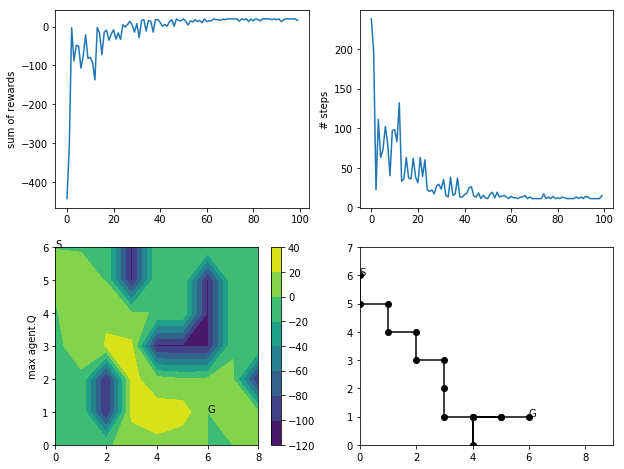

In [95]:
plot_train(agent, rtrace, steps, trace, start)

#### Trained maze with above parameter values.
#### sum of rewards plots shows total rewards obtained in each iteration. Initially, rewards are very less which indicates it failed to reach goal. Upon increase in iterations, Q values are updated and optimal path is obtained which can be observed from increase in rewards.

#### Steps explain number of steps taken to reach goal. Initially agent took greater than 200 steps to reach goal and this number gradually reduced to below 10 upon training.

#### Q values can be seen on all states in contour plot.

#### Trace plot shows the path to reach goal from a starting point in maze.

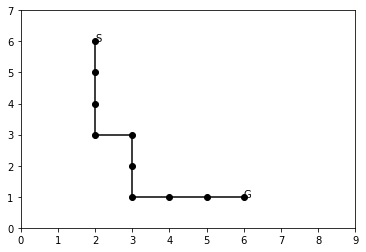

In [96]:
test_start = [0,2]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)

#### [0,2] is the test state to start in maze, the path it followed to reach goal using Q table values is shown.

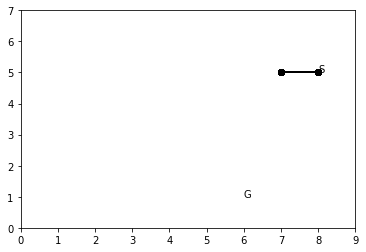

In [97]:
test_start = [1,8]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)

#### [1,8] is the test state to start in maze, the path it followed to reach goal using Q table values is shown.

## Experimental outputs that show the choice of parameters. How do you choose them? 

#### Maze - Choice of alpha and epsilon vs Rewards

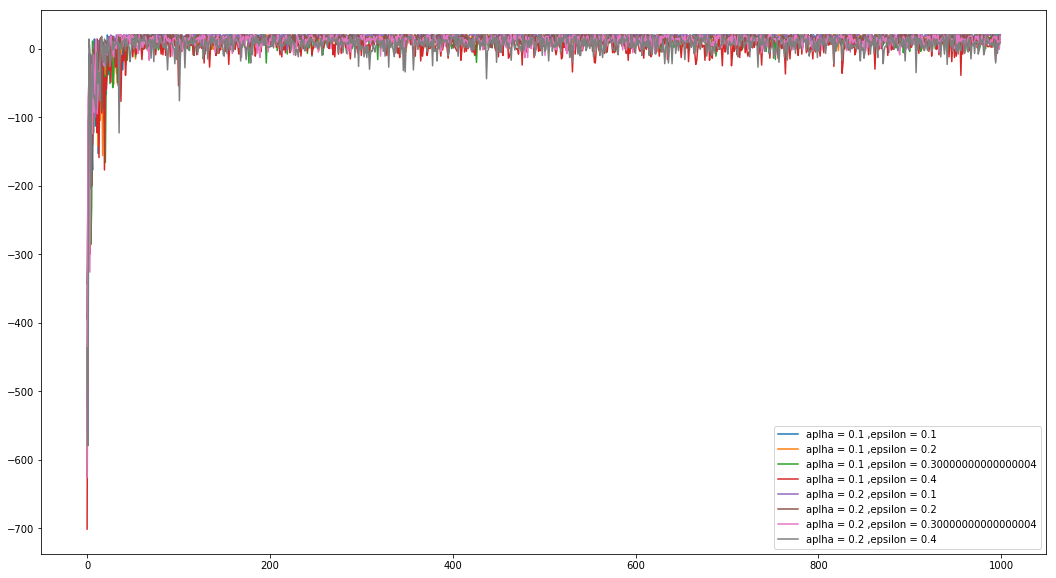

In [131]:
fig = plt.figure(figsize=(18,10));    
for _alpha in range(1,3,1):
    for _eps in range(1,5,1):
        agent = RLAgent(env)
        start = [0,0]
        rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha=0.1 *_alpha, 
                                   epsilon=0.1 *_eps, 
                                   maxiter=1000, 
                                   maxstep=1000)
        plt.plot(rtrace,label='aplha = '+str(0.1 *_alpha)+' ,epsilon = '+str(0.1 *_eps));
plt.legend();

Trained the model with alpha of 0.1,0.2 and epsilon of 0.1 to 0.4. Rewards for each iteration are plotted and select parameters that produce less negative rewards.

#### Maze - Choice of alpha and epsilon vs Steps

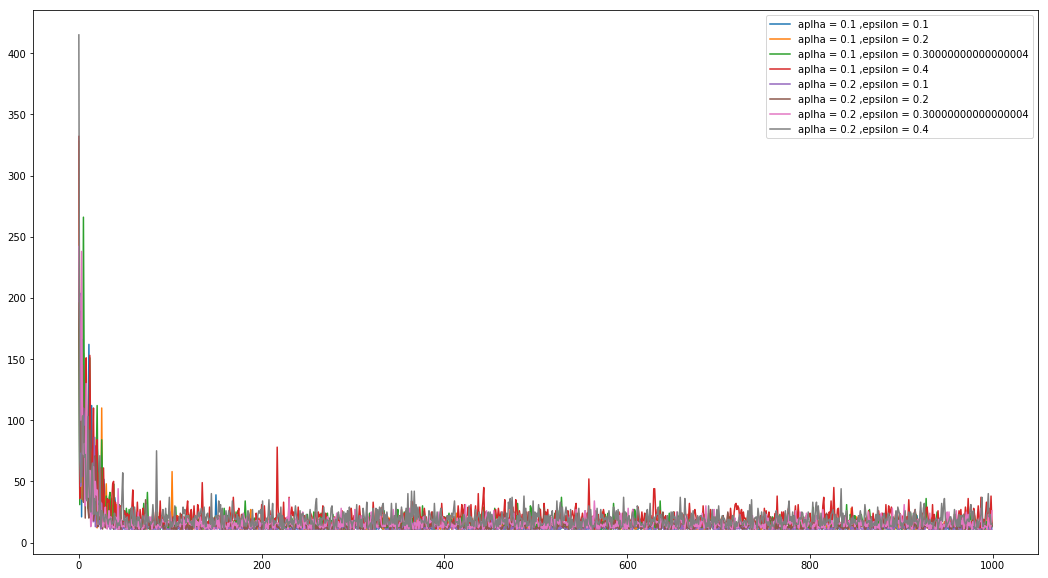

In [132]:
fig = plt.figure(figsize=(18,10));    
for _alpha in range(1,3,1):
    for _eps in range(1,5,1):
        agent = RLAgent(env)
        start = [0,0]
        rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha=0.1 *_alpha, 
                                   epsilon=0.1 *_eps, 
                                   maxiter=1000, 
                                   maxstep=1000)
        plt.plot(steps,label='aplha = '+str(0.1 *_alpha)+' ,epsilon = '+str(0.1 *_eps));
plt.legend();

Trained the model with alpha of 0.1,0.2 and epsilon of 0.1 to 0.4. Total steps for each iteration are plotted and select parameters that produce less steps.

### Selected parameters of Maze
 alpha = 0.1  
 epsilon = 0.2  
 gamma = 0.99  
 maxiter = 1000   
 maxsteps = 1000  
 
On observing above graphs, we get maximum rewards ,minimum steps for these parameters. Maze can be explored completely with optimal values and find a path from any given point.

### Output Plots

#### Maze training plots

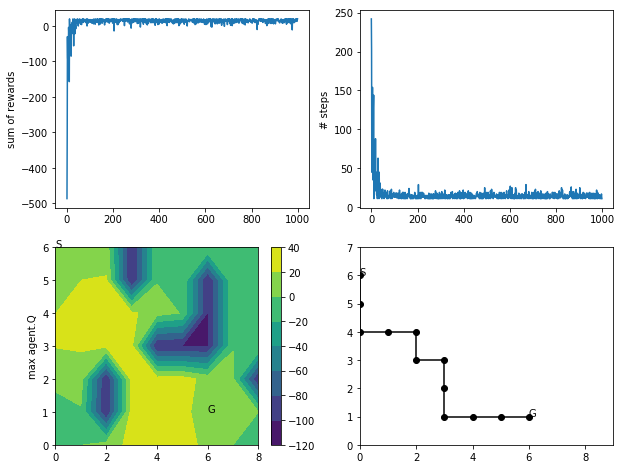

In [137]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha=0.1, 
                                   epsilon=0.2, 
                                   maxiter=1000, 
                                   maxstep=1000)
plot_train(agent, rtrace, steps, trace, start)

We train the model with modified parameters and output plots are plotted again. This time we can see decrease in negative rewards, steps taken and path from start to goal is optimized.

#### Maze Test path

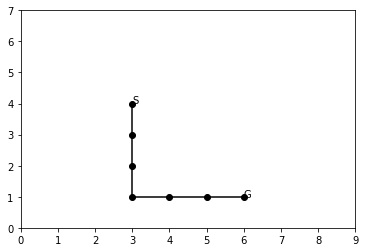

In [138]:
test_start = [2,3]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)

Given a test start state of (2,3), we are able to get best path to goal.

### Initial Parameters of Poker  
alpha = 0.1  
epsilon = 0.1  
gamma = 0.99  
maxiter = 100


### Training and Testing with Poker

Training poker with above parameters on 100 games.

In [158]:
poker = createEnv()
pkrAgent = pokerAgent(poker)
wins_Train, rewards_Train = pkrAgent.train(gamma=0.99, alpha=0.1, epsilon=0.1, maxiter=100)
wins_Test, rewards_Test = pkrAgent.test(10)

Test our trained model on 10 games and observe win percentage in both train and test cases as below

#### Training and Test results

In [159]:
print('Train win percentage= {}\n Test win percentage= {}'.format(wins_Train, wins_Test))

Train win percentage= 60.0
 Test win percentage= 70.0


We can observe there is a win percentage of 70 in test games.

#### Poker Rewards in Training

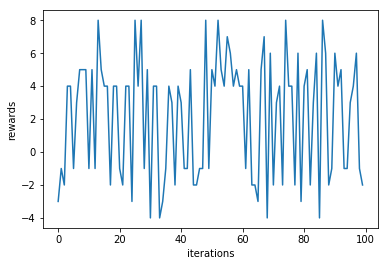

In [160]:
fig = plt.figure(figsize=(6,4));
plt.plot(rewards_Train);
plt.ylabel("rewards");
plt.xlabel("iterations");

Total rewards of player for each game is plotted. When player wins reward will be positive, when player loss the game reward will be negative.

#### Train and Test Win percentage

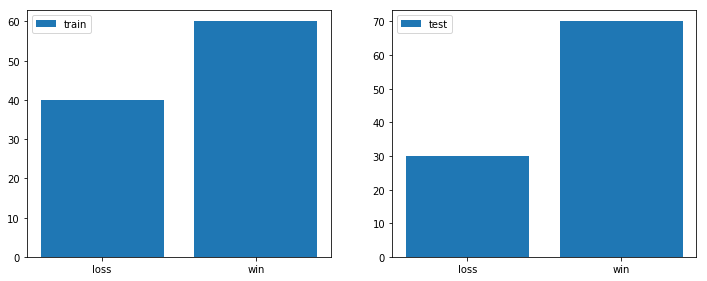

In [161]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(221)
plt.bar(['win','loss'],[wins_Train,(100 - wins_Train)], label = 'train');
plt.legend();
ax1 = fig.add_subplot(222)
plt.bar(['win','loss'],[wins_Test,(100 - wins_Test)], label = 'test');
plt.legend();

The above 2 plots describe the win percentge and loss percentage of player in train and test cases.

### Poker - Win Percentage vs Number of Iterations

In [177]:
iters = []
wins_Train_Poker = []
wins_Test_Poker = []
testgames = []
for i in range(1000,10000,1000):
    poker = createEnv()
    pkrAgent = pokerAgent(poker)
    games = int(i/10)
    testgames.append(games)
    wins_Train, rewards_Train = pkrAgent.train(gamma=0.99, alpha=0.1, epsilon=0.1, maxiter=i)
    wins_Test, rewards_Test = pkrAgent.test(games)
    wins_Train_Poker.append(wins_Train)
    wins_Test_Poker.append(wins_Test)
    iters.append(i)

#### Poker - Win Percentage of Train data based on maxiterations of training

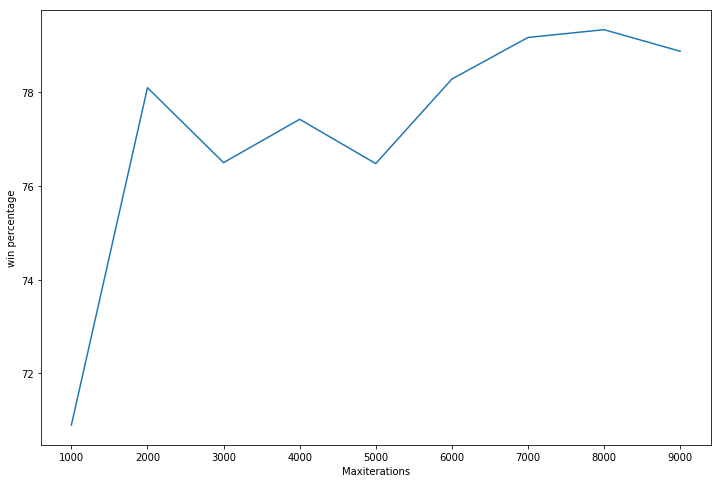

In [178]:
fig = plt.figure(figsize=(12,8));
plt.plot(iters, wins_Train_Poker);
plt.ylabel("win percentage");
plt.xlabel("Maxiterations");

#### When model is trained on large number of games, win percentage of train games tend to increase.

#### Poker - Win Percentage of Test data based on maxiterations of training

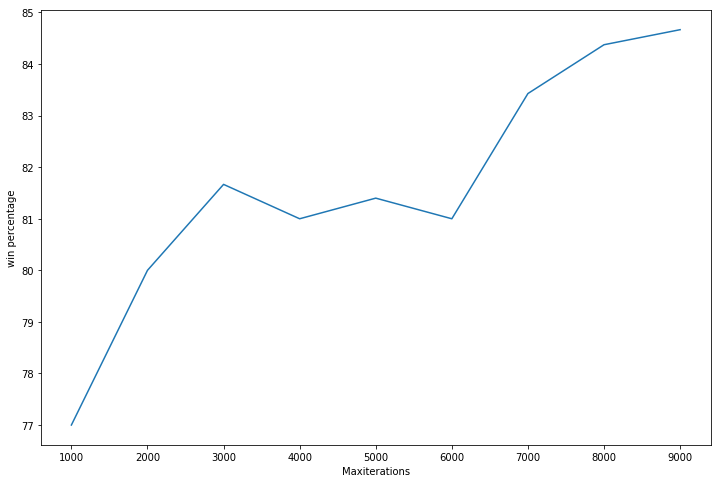

In [179]:
fig = plt.figure(figsize=(12,8));
plt.plot(iters, wins_Test_Poker);
plt.ylabel("win percentage");
plt.xlabel("Maxiterations");

#### When model is trained on large number of games, win percentage of test games tend to increase.

##### Poker - Choice of alpha with maxiterations

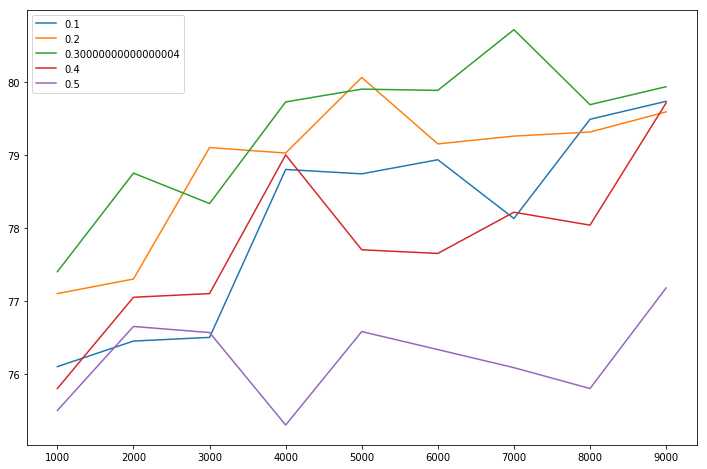

In [180]:
fig = plt.figure(figsize=(12,8));
#ax = fig.add_subplot(221)
for _alpha in range(0,5,1):
    iters = []
    wins_Train_Poker = []
    wins_Test_Poker = []
    testgames = []
    for i in range(1000,10000,1000):
        poker = createEnv()
        pkrAgent = pokerAgent(poker)
        games = int(i/10)
        testgames.append(games)
        wins_Train, rewards_Train = pkrAgent.train(gamma=0.99, alpha=0.1+(_alpha*0.1), epsilon=0.1, maxiter=i)
        wins_Test, rewards_Test = pkrAgent.test(int(i/10))
        wins_Train_Poker.append(wins_Train)
        wins_Test_Poker.append(wins_Test)
        iters.append(i)
    plt.plot(iters, wins_Train_Poker, label = 0.1+(_alpha*0.1));
plt.legend();

#### Win percentageis more for learnig rate alpha= 0.3 for less number of games. When number of iterations are increased, win percentage increases for alpha = 0.1

#### Poker - Choice of alpha and epsilon with maxiterations

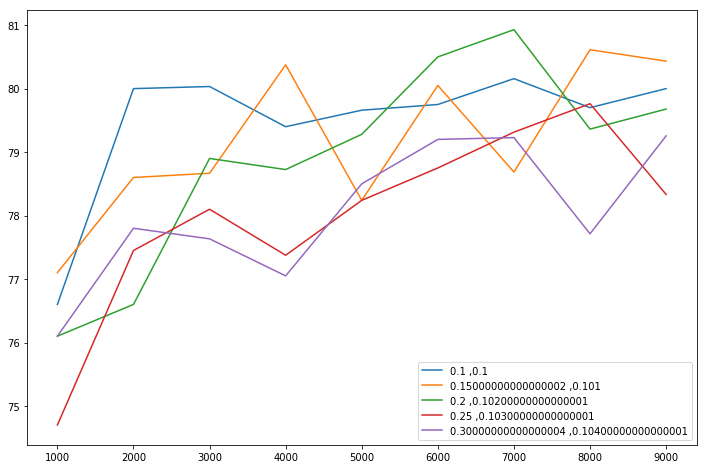

In [196]:
fig = plt.figure(figsize=(12,8));
#ax = fig.add_subplot(221)
for val in range(0,5,1):
    iters = []
    wins_Train_Poker = []
    wins_Test_Poker = []
    testgames = []
    for i in range(1000,10000,1000):
        poker = createEnv()
        pkrAgent = pokerAgent(poker)
        games = int(i/10)
        testgames.append(games)
        wins_Train, rewards_Train = pkrAgent.train(gamma=0.99, alpha=0.2+(val*0.05), epsilon=0.1+(0.001*val), maxiter=i)
        wins_Test, rewards_Test = pkrAgent.test(int(i/10))
        wins_Train_Poker.append(wins_Train)
        wins_Test_Poker.append(wins_Test)
        iters.append(i)
    plt.plot(iters, wins_Train_Poker, label = str(0.1+(val*0.05))+" ,"+ str(0.1+(0.001*val)));
plt.legend();

#### Model is trained for different values of alpha and epsilon. We are more successful when alpha is between 0.1 and 0.2 and epsilon nearly 0.1

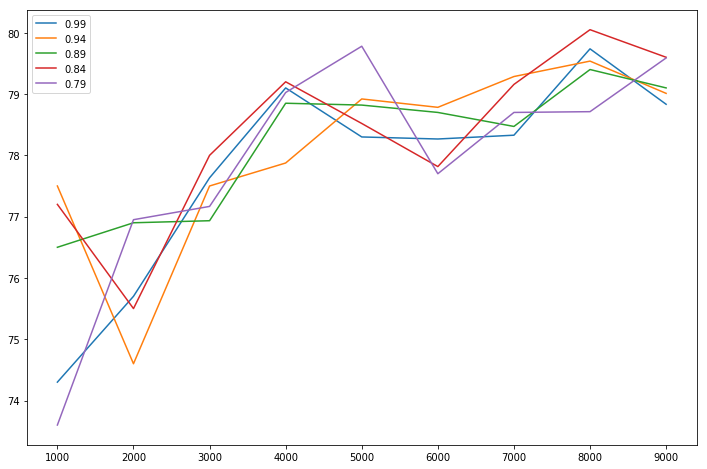

In [201]:
fig = plt.figure(figsize=(12,8));
#ax = fig.add_subplot(221)
for _gamma in range(0,5,1):
    iters = []
    wins_Train_Poker = []
    wins_Test_Poker = []
    testgames = []
    for i in range(1000,10000,1000):
        poker = createEnv()
        pkrAgent = pokerAgent(poker)
        games = int(i/10)
        testgames.append(games)
        wins_Train, rewards_Train = pkrAgent.train(gamma=0.99-(_gamma*0.05), alpha=0.1, epsilon=0.1, maxiter=i)
        wins_Test, rewards_Test = pkrAgent.test(int(i/10))
        wins_Train_Poker.append(wins_Train)
        wins_Test_Poker.append(wins_Test)
        iters.append(i)
    plt.plot(iters, wins_Train_Poker, label = 0.99-(_gamma*0.05));
plt.legend();

We can observe that better value of gamma can be 0.99 as graph reduced and increased steadily with iterations.

### Selected Parameters of Poker 

Based on above observations, we can find the below parameters are more likely to be successful.

alpha = 0.15  
epsilon = 0.1  
gamma = 0.99  
maxiter = 10000

Train our player with above parameters and test on new games

In [202]:
poker = createEnv()
pkrAgent = pokerAgent(poker)
wins_Train, rewards_Train = pkrAgent.train(gamma=0.99, alpha=0.15, epsilon=0.1, maxiter= 10000)
wins_Test, rewards_Test = pkrAgent.test(10000)

#### Training and Test results

In [203]:
print('Train win percentage= {}\n Test win percentage= {}'.format(wins_Train, wins_Test))

Train win percentage= 80.60000000000001
 Test win percentage= 82.80999999999999


#### We can observe win percentages of both train and test improved from 60 to 80.6 and 70 to 82.8 respectively.

### Output Plots

#### Poker Rewards in Training

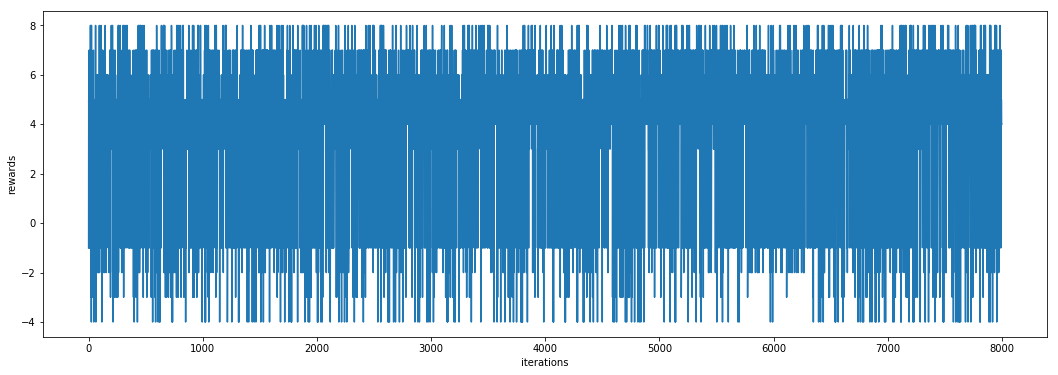

In [183]:
fig = plt.figure(figsize=(18,6));
plt.plot(rewards_Train);
plt.ylabel("rewards");
plt.xlabel("iterations");

Rewards of each game are plotted as above. There is an increase in positive rewards compared to previous plot with initial parameters.

#### Train and Test Win percentage

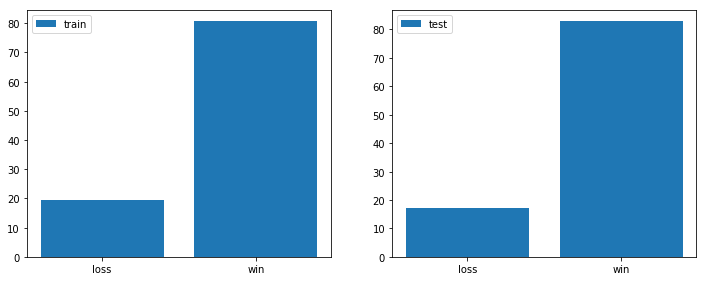

In [204]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(221)
plt.bar(['win','loss'],[wins_Train,(100 - wins_Train)], label = 'train');
plt.legend();
ax1 = fig.add_subplot(222)
plt.bar(['win','loss'],[wins_Test,(100 - wins_Test)], label = 'test');
plt.legend();

We can observe loss percent reduced in both train and test games after modifying parameters to train model.

In [208]:
iters = []
wins_Train_Poker = []
wins_Test_Poker = []
testgames = []
for i in range(1000,10000,1000):
    poker = createEnv()
    pkrAgent = pokerAgent(poker)
    games = int(i/10)
    testgames.append(games)
    wins_Train, rewards_Train = pkrAgent.train(gamma=0.99, alpha=0.15, epsilon=0.1, maxiter=i)
    wins_Test, rewards_Test = pkrAgent.test(games)
    wins_Train_Poker.append(wins_Train)
    wins_Test_Poker.append(wins_Test)
    iters.append(i)

#### Poker - Win Percentage of Train data based on maxiterations of training

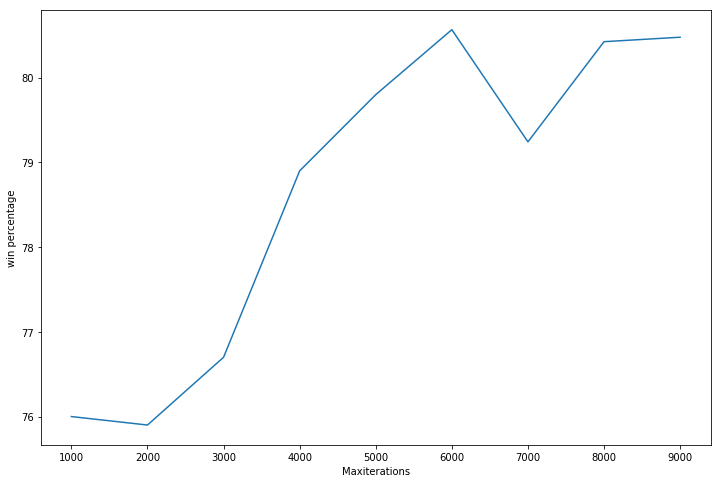

In [209]:
fig = plt.figure(figsize=(12,8));
plt.plot(iters, wins_Train_Poker);
plt.ylabel("win percentage");
plt.xlabel("Maxiterations");

When model is trained on large number of games, win percentage of train games tend to increase.

# V. Conclusions

I got clear understanding of Reinforcement Learning algorithm and I am able to implement TD learning with Q-Learning approach to find values of Q table using rewards,state in both maze and poker problems. The most challenging part of this assignment is choosing parameters such as alpha, epsilon, gamma. I tried with different parameters to train models and used obtained Q values to play maze and poker.

An increase in epsilon value to 0.2 produced better results in maze problem. I updated Q values in poker problem by taking reward in round 2 and modified state of round 1 inaddition to round2 state.This increased win percentage by a good margin.

# References

http://nbviewer.jupyter.org/url/webpages.uncc.edu/mlee173/teach/itcs6156/notebooks/notes/Note-ReinforcementLearning.ipynb
https://towardsdatascience.com/introduction-to-various-reinforcement-learning-algorithms-i-q-learning-sarsa-dqn-ddpg-72a5e0cb6287

# Extra Credit

- Let us have Poker Tournament in class (Nov 6th.)!
- Top 4 (or more) students will get an extra credit. 
- 2 (or more?) unique training attemps will also get an extra credit. (Sales for it to be considered.) 

## Grading

We will test your notebook with an additional grid.txt file. Please make sure to test in different maze input files. 

points | | description
--|--|:--
5 | Overview| states the objective and the appraoch 
10 | Maze Problem | 
 | 5| Includes description of maze problem
 | 5| Explains the GridWorld
10 | Poker 
 | 5| Includes description of poker problem
 | 5| Explains the Poker
25 | Methods | 
 | 5| Review of the SARSA and Q-Learning
 | 5| Choice of TD learning and Reason
 |10| Implementation of the selected approach
 | 5| explanation of the codes
45 | Results 
| 5| Reports the selected parameters for both problems. 
|20| Experimental outputs that show the choice of parameters. How do you choose them? (10 points per each problem)
|10| Output plots (5 for each)
|10| reading and analysis of learning results and plots (5 for each)
5 | Conclusions 
